In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.pylab as pl
# import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import decimal
from scipy.integrate import simps


In [2]:
def moving_avg(x_data,window):
    # return x_data
    return np.convolve(x_data,np.ones(int(window)),'valid')/window


(88,)
0.0 1.0 0.1107651086786913 0.1107651086786913 1 1
0.3 0.1 0.11085452645143279 0.1107651086786913 1 1
1.5 2.0 0.09434020640534443 0.1107651086786913 3 2
2.0 0.3 0.1429197123010345 0.1107651086786913 1 3
2.0 100.0 0.019064601329971405 0.1107651086786913 2 2


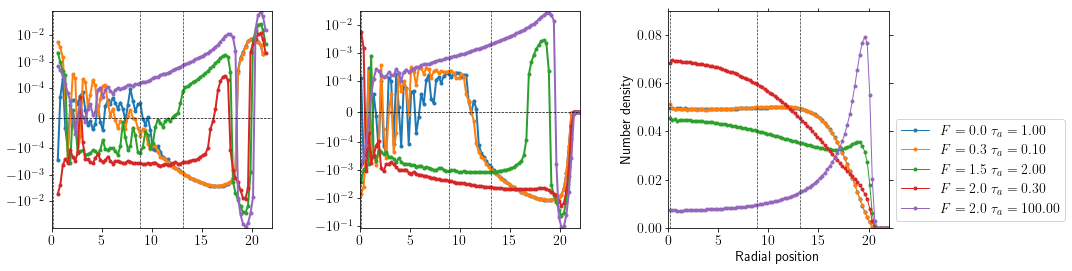

In [76]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True})
fig,[ax1,ax2,ax]=plt.subplots(1,3,figsize=(15,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})

def func(xi,a,b,c,d,e,f,g):
    return a+b*(xi-c)**f+d*(xi-e)**g

ind=4
fpath='../../data/SAC_exp/'
for (name,tp) in [('low',0.01)]:#,('mid',1.0), ('high',100.)]:
    Ts,Fs,Tas=[],[],[]
    Rmax=[]
    Rp=[]
    Rpp=[]
    betas=[]
    conf=[]
    err2=[]

    ax.clear()
    colors = pl.cm.hot(np.linspace(0,1,15))
    colors=['r','c','m','g','b']
    count=0
    wval=3

    for fname in os.listdir(fpath+'RDP/'):
        if '.npz' in fname and 'RadNumDens' in fname:# and 'rep2' in fname:
            # print(fname.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            
            
            if F==0 and Ta==1:
                npzfile=np.load(fpath+'RDP/'+fname)
                nbins=npzfile['bins'].shape[0]
                n0,n1,n2=int(nbins*0.),int(nbins*0.4), int(nbins*0.6)
                p1_eq=simps(npzfile['bins'][n0:n1]**2*4*np.pi*npzfile['hist'][n0:n1]/1200,npzfile['bins'][n0:n1])
                p2_eq=simps(npzfile['bins'][n1:n2]**2*4*np.pi*npzfile['hist'][n1:n2]/1200,npzfile['bins'][n1:n2])
                p3_eq=np.mean(npzfile['hist'][int(0.6*nbins):])

                hist_eq=npzfile['hist']
                bin_eq=npzfile['bins']
                print(npzfile['hist'].shape)

                # p1_eq=np.max(npzfile['hist'][n0:n1])


    for fname in os.listdir(fpath+'RDP/'):
        if '.npz' in fname and 'RadNumDens' in fname:# and 'rep2' in fname:
            # print(fname.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            # if F==0: continue
            npzfile=np.load(fpath+'RDP/'+fname)
            beta=F**2*Ta/(0.1*T*0.0083)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)
            betas.append(beta)
            conf.append(F*Ta/(0.1*R0))

            # print(npzfile['hist'].shape)

            dp=np.gradient(npzfile['hist'])/np.gradient(npzfile['bins'])
            ddp=np.gradient(dp)/np.gradient(npzfile['bins'])
           
            # dp=moving_avg(dp,2*wval)
            ddp=moving_avg(ddp,2*wval)

            Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
            Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]

            p1=simps(npzfile['bins'][n0:n1]**2*4*np.pi*npzfile['hist'][n0:n1]/1200,npzfile['bins'][n0:n1])
            p2=simps(npzfile['bins'][n1:n2]**2*4*np.pi*npzfile['hist'][n1:n2]/1200,npzfile['bins'][n1:n2])
            p3=simps(npzfile['bins'][n2:]**2*4*np.pi*npzfile['hist'][n2:]/1200,npzfile['bins'][n2:])

            # p1=np.max(npzfile['hist'][n0:n1])
            # print(npzfile['hist'].shape)
            # err2.append(np.sum((hist_eq-npzfile['hist'][:len(hist_eq)])**2))
                

            #check at boundary if there is a peak: dp should cross zero once
            cross_count_dp=0
            for ix in range(n2,len(dp)-1):
                if np.sign(dp[ix])!=np.sign(dp[ix+1]):
                    cross_count_dp+=1

            cross_count_ddp=0
            for ix in range(n2,len(ddp)-1):
                if np.sign(ddp[ix])!=np.sign(ddp[ix+1]):
                    cross_count_ddp+=1
            
            state=None

            # if cross_count_dp==1 and p1>p1_eq: state='center-collapse'

            if cross_count_dp==2: state='boundary-peak'
            elif cross_count_dp>2: state='coex'

            else: state='eq-like'
            
            # elif cross_count_dp==1 and cross_count_ddp>1 and p1<p1_eq:
            #     Rp.append(3)
            #     print('yosemite')
                
            # else: Rp.append(0)

            Rp.append(state)
            Rpp.append(p1)

            if F==0 and Ta==1: 
                Fs.append(0)
                Tas.append(0.01)
                Rp.append(state)
                Rpp.append(p1)

            if (F==0 and Ta==1) or (F==0.3 and Ta==0.1) or (F==2 and Ta==0.3) or (F==1.5 and Ta==2) or (F==2 and Ta==100):
                print(F,Ta, p1,p1_eq, cross_count_dp,cross_count_ddp)
                # ax1.plot(npzfile['bins'],ddp, '.-',label='$F={:.1f}\ \\tau_a={:.2f}$'.format(F,Ta),lw=2,)
                ax2.plot(npzfile['bins'],dp, '.-',label='$F={:.1f}\ \\tau_a={:.2f}$'.format(F,Ta),lw=2,)
                
                ax1.plot(npzfile['bins'][wval-1:-wval],ddp, '.-',label='$F={:.1f}\ \\tau_a={:.2f}$'.format(F,Ta),lw=2,)
                # ax2.plot(npzfile['bins'][wval-1:-wval],dp, '.-',label='$F={:.1f}\ \\tau_a={:.2f}$'.format(F,Ta),lw=2,)
                ax.plot(npzfile['bins'],npzfile['hist'], '.-',label='$F={:.1f}\ \\tau_a={:.2f}$'.format(F,Ta),lw=1,)

                # print(F,Ta, np.mean(npzfile['hist'][:n1])-p1_eq)

    for axi in [ax,ax1,ax2]:
        axi.axvline(npzfile['bins'][n0],c='0.2',ls='--',lw=0.7)
        axi.axvline(npzfile['bins'][n1],c='0.2',ls='--',lw=0.7)
        axi.axvline(npzfile['bins'][n2],c='0.2',ls='--',lw=0.7)
        axi.axhline(0, c='k',ls='--', lw=0.7)

        axi.set_xlim(0,22)
    

    ax.set_xlabel('Radial position')
    ax.set_ylabel('Number density')
    ax.set_ylim(0,0.09)
    ax.legend(loc='lower left', bbox_to_anchor=(1,0))
    
    ax1.set_yscale('SymLog',linthresh=1e-4)
    ax2.set_yscale('SymLog',linthresh=1e-4)

    # ax.axvline(20)
    # ax.axvline(19)
    fig.savefig(fpath+'plots/RDP.png'.format(name), dpi=300, bbox_inches='tight')
    # fig.savefig(fpath+'plots/RDP_{}Ta.png'.format(name), dpi=300, bbox_inches='tight')


138 138 139


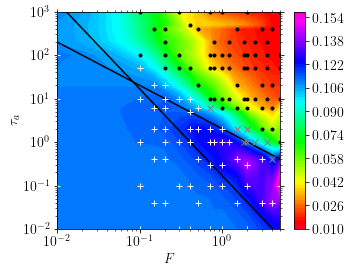

In [77]:
fig,ax=plt.subplots(1,1,figsize=(5,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
ax.clear()
print(len(conf), len(betas), len(Rpp))
# Xi,Yi=np.meshgrid(np.geomspace(0.01,5,40),np.logspace(-2,3,40))
Xi,Yi=np.meshgrid(np.unique(Fs),np.unique(Tas))
# Xi,Yi=np.meshgrid(np.unique(conf),np.unique(betas))
Xp,Yp=np.meshgrid(np.logspace(-4,1,100), np.logspace(-4,4,100))
triang=tri.Triangulation(Fs,Tas)
# triang=tri.Triangulation(conf,betas)
interpZ=tri.LinearTriInterpolator(triang,np.array(Rpp))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.01,0.16,0.002),cmap='gist_rainbow',)
plt.colorbar()
plt.contour(Xp,Yp,Xp**2*Yp/(0.1*0.0083*200), levels=[1],colors='k',)
plt.contour(Xp,Yp,Xp*Yp/(0.1*20), levels=[1],colors='k',)
# plt.contour(Xi,Yi,Xi*Yi/(0.1*40), levels=[1],colors='k',alpha=0.3)

for ix in range(len(Fs)):
    if Rp[ix]=='eq-like':
        plt.plot(Fs[ix],Tas[ix],'w+',)
    elif Rp[ix]=='boundary-peak':
        plt.plot(Fs[ix],Tas[ix],'k.',)
    elif Rp[ix]=='coex':
        plt.plot(Fs[ix],Tas[ix],'x',c='0.5')
    # elif Rp[ix]==3:
    #     plt.plot(Fs[ix],Tas[ix],'k.',)

# interpZp=tri.LinearTriInterpolator(triang,np.around(np.array(Rpp), 3))
# Zp=interpZp(Xi,Yi)
# plt.contourf(Xi, Yi, Zp, levels=[0,1,2], hatches=['/','.','////'], colors='None')
# plt.colorbar()
# plt.contour(Xi, Yi, Zi, levels=[1,], colors='k')
# plt.contour(Xi, Yi, Zp, levels=[1.], colors='k')
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)
# plt.plot(Fs,Tas,'k+',)
# for fval,taval,lc in [(0.0,1.0,'r'),(0.3,1,'c'),(2,1,'m'),(2,100,'b'),(0.3,100,'g')]:
    # plt.plot(fval,taval,'o',markersize=10,color=lc)

plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
# plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.01,5)
plt.ylim(0.01,1e3)
# plt.axhline(10,c='k')
plt.savefig(fpath+'plots/RDP_regime_diag.png', dpi=300, bbox_inches='tight')


In [15]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=200
fpath='../../data/SAC_AB/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens_A' in fname and 'rep1' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        if kb==5: continue
        if T==T0:
            npzfile=np.load(fpath+fname)
       
            b_act=F**2*Ta/(0.1*0.0083*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
            Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
            Rsd=np.sqrt(simps((npzfile['bins']-Rav)**2*4*np.pi*npzfile['bins']*npzfile['hist']/1200,npzfile['bins']))
            # print(Rav)

            Rav=np.mean(npzfile['hist'][1:5])
            Rmax.append((F,Ta,b_act,Rav, Rsd**2/Rav))
        
print(len(Rmax))
Xi,Yi=np.meshgrid(np.logspace(-1,1,10),np.logspace(0,3,10))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,[xx[3] for xx in Rmax])#, kind='geom')
Zi=interpZ(Xi,Yi)
# plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,0.2,0.01),cmap='RdBu')
# plt.colorbar()
plt.plot([xx[2] for xx in Rmax],[xx[3] for xx in Rmax],'o')
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[10],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

# plt.plot(Fs,Tas,'.',c='b',markersize=5)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
plt.title('Average radial position ($T={:.0f}$)'.format(T0))

plt.loglog()
# plt.savefig('../../plots/Rouse/avg_radial_pos_Ft_T200.png', dpi=300,bbox_inches='tight')

NameError: name 'cm' is not defined

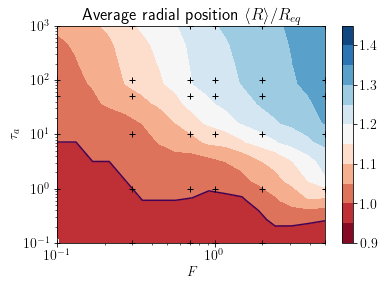

In [41]:
ind=4
# norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
# cmap = mpl.colors.gist_rainbow
# m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
Rav_eq=0
fpath='../../data/SAC_exp/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        
        npzfile=np.load(fpath+fname)
    
        b_act=F**2*Ta/(0.1*0.0083*T)

        betas.append(b_act)
        Ts.append(T)
        Tas.append(Ta)
        Fs.append(F)
        Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
        Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
        Rmax.append(Rav)

        if F==0: Rav_eq=Rav

Xi,Yi=np.meshgrid(np.geomspace(0.05,5,20),np.logspace(-2,3,15))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,np.around(np.array(Rmax)/Rav_eq, 2))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.9,1.5,0.05),cmap='RdBu')
plt.colorbar()
plt.contour(Xi, Yi, Zi, levels=[1])
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Fs,Tas,'k+',)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.1,5)
plt.ylim(0.1,1e3)
plt.savefig('../../data/SAC_exp/plots/normAvgR_contour.png', dpi=300, bbox_inches='tight')

In [34]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
for fpath in ['../../data/ROUSE_chain_confined_Ns/']:#,'../../data/ROUSE_chain_confined_Ns/N300/']:

    for fname in os.listdir(fpath):
        if '.npz' in fname and 'RDP' in fname:
            # print(fname)#.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            if R0!=10: continue
            npzfile=np.load(fpath+fname)
            # print(npzfile['bins'].shape)
        
            b_act=F**2*Ta/(0.1*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist'][0]==npzfile['hist'][0].max())][0]
            Rmax.append(Rm/R0)

Xi,Yi=np.meshgrid(np.logspace(0,3,10),np.logspace(-3,3,20))
triang=tri.Triangulation(Tas, betas)
interpZ=tri.LinearTriInterpolator(triang,Rmax)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,1.2,0.1),cmap='RdBu')
plt.colorbar()

# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Tas,betas,'.',c='b',markersize=5)

plt.loglog()


KeyboardInterrupt: 

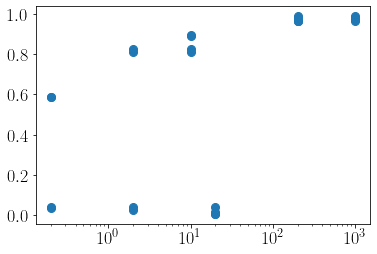

In [123]:
plt.semilogx(betas,Rmax,'o')

Text(0, 0.5, '$F^2\\tau_a/(\\gamma T)$')

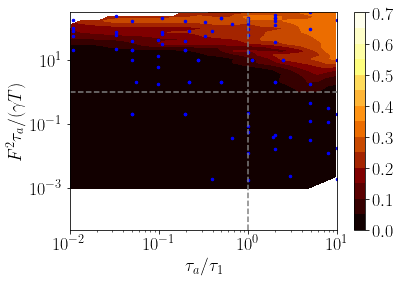

In [598]:
Xi,Yi=np.meshgrid(np.logspace(-3,2,50),np.logspace(-3,4,60))
triang=tri.Triangulation(X,Y)
interpZ=tri.LinearTriInterpolator(triang,Z)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.linspace(0,0.7,15),cmap='afmhot')#,alpha=0.6)
        #ax.contour(Xi, Yi, Zi,colors='k',levels=levels,linewidths=0.3)


plt.plot(X,Y,'.',c='b',markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,10)
plt.ylim(5e-5,3e2)
plt.axhline(1,c='0.5',ls='--',)
plt.axvline(1,c='0.5',ls='--',)

# plt.grid(True,alpha=0.5,which='both')

plt.colorbar()
plt.xlabel('$\\tau_a/\\tau_1$')
plt.ylabel('$F^2\\tau_a/(\gamma T)$')
# plt.savefig('../plots/Rouse/RC_RDP_phase_diag.png',dpi=300, bbox_inches='tight')

#confined_N300 and _N100_new

In [545]:
f=0.003
T=0.8
Ta=350
t1=tau_p(1,5,300)
print('{:.1f} {:.3f} {:.3f}'.format(t1, Ta/t1,f**2*Ta/(0.02*T)))


182.4 1.919 0.197


In [427]:
a=np.array([1,32,4])
b=np.array([4,3,8])

print((a-b)**2)

[  9 841  16]
